In [46]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("coolwarm")
plt.style.use('ggplot')
import plotly.express as px

from scipy import stats
from statsmodels.stats.stattools import durbin_watson

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import tkinter as tk
from functools import partial

import warnings
warnings.filterwarnings('ignore')

In [47]:
# Hide Code blocks from HTML

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Introduction

This project utilizes a variety of linear regression algorithms in order to predict the housing price in the city of Boston, or `MEDV`. These are all of the variables in the dataset. This data is maintained in the `datasets` module of `sklearn` but it can also be found online on the UCI Machine Learning Repository or from Kaggle.com. 

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per \$10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of African-Americans by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000s
    
So first we will read in the data. 

In [48]:
# loading data
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df['MEDV'] = boston.target

We already know this data has no missing values, but we can look at the top of the dataset and the summary of the dataset itself.

In [49]:
# Looking at the top of the dataset
print(df.head())
# Checking for missing values
# print(df.isnull().any())
print(df.describe())

       CRIM    ZN  INDUS  CHAS   NOX    RM   AGE   DIS  RAD    TAX  PTRATIO  \
0  6.32e-03  18.0   2.31   0.0  0.54  6.58  65.2  4.09  1.0  296.0     15.3   
1  2.73e-02   0.0   7.07   0.0  0.47  6.42  78.9  4.97  2.0  242.0     17.8   
2  2.73e-02   0.0   7.07   0.0  0.47  7.18  61.1  4.97  2.0  242.0     17.8   
3  3.24e-02   0.0   2.18   0.0  0.46  7.00  45.8  6.06  3.0  222.0     18.7   
4  6.91e-02   0.0   2.18   0.0  0.46  7.15  54.2  6.06  3.0  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
           CRIM      ZN   INDUS    CHAS     NOX      RM     AGE     DIS  \
count  5.06e+02  506.00  506.00  506.00  506.00  506.00  506.00  506.00   
mean   3.61e+00   11.36   11.14    0.07    0.55    6.28   68.57    3.80   
std    8.60e+00   23.32    6.86    0.25    0.12    0.70   28.15    2.11   
min    6.32e-03    0.00    0.46    0.00    0.39    3.56    2.90    1.13   


So note that there are no missing variables, although it should be noted that the `CHAS` and `RAD` variables are categorical rather than continuous variables. 

### Data Visualization
As an introductory step it is good to visualize the response variable against the target variables. 

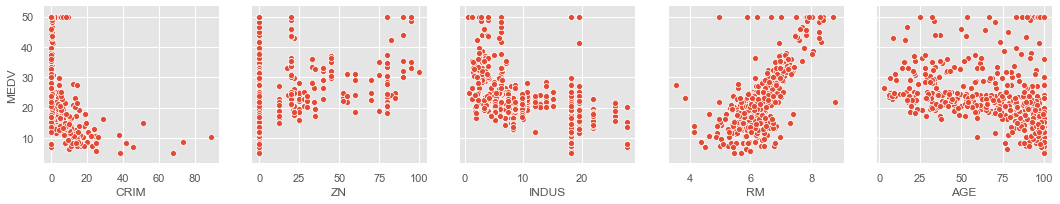

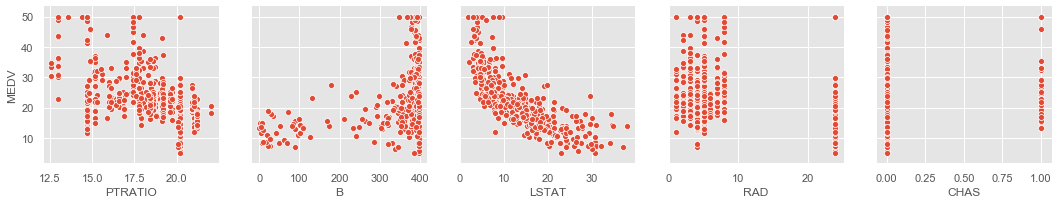

In [50]:
# response vs the continuous target variables
sns.pairplot(data = df, height = 3,
             y_vars = ['MEDV'],
             x_vars = ['CRIM', 'ZN', 'INDUS', 'RM', 'AGE'])

sns.pairplot(data = df, height = 3, y_vars = ['MEDV'],
            x_vars = ['PTRATIO', 'B', 'LSTAT', 'RAD', 'CHAS'])

A cursory glance at the scatterplots of the response and target variables show that `RM` and `LSTAT` have something of a linear relationship with `MEDV`. The rest of the variables don't seem to show much of a correlation. We can scrutinize this further by looking at a correlation matrix. This will help us determine which features to include in the final model, a process known as _feature selection_.

## Feature Selection

### Correlation Matrix
This will tell us if any of the features are highly correlated with one another, which is bad since one of the assumptions of regression is that the features are independent from one another. We can also look at how the response variable correlates with the features. 

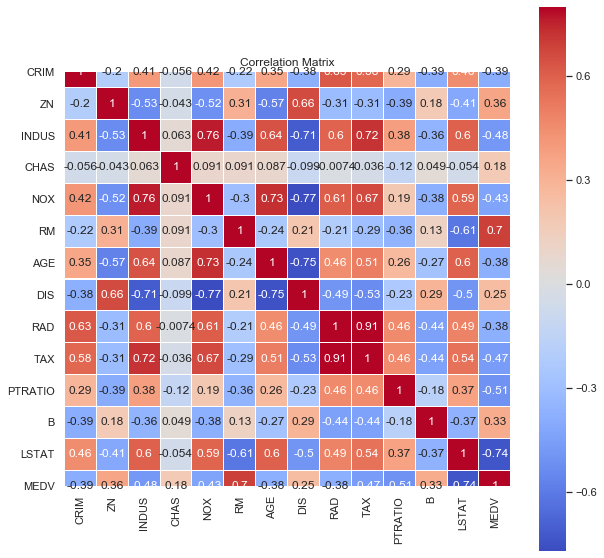

In [51]:
# Setting style for seaborn
sns.set_context("notebook")
sns.set_style("darkgrid")

# 2 significant figures
pd.set_option('precision', 2)

# Correlation matrix
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'coolwarm', linecolor = 'white')
plt.title('Correlation Matrix')
plt.show()

As we expected from our graphs, we notice that the features that correlate the highest with `MEDV` are `RM`, the average number of rooms, and `LSTAT`, the percent lower status of the population.

`DIS`, which is weighted distances to Boston's employment centers, has a strong negative correlation with 3 variables: `INDUS`, the proportion of non-business acres, `NOX`, the concentration of nitric oxides,  and `AGE`, the proportion of homes built before 1940.

### Multicollinearity
In building regression models we don't want to have highly correlated features, otherwise known as _multicollinearity_. Multicollinearity can result in inaccurate estimations of the regression coefficients, give false p-values when conducting tests, and worst of all, degrade the predictability of the model, among other problems.

In general when building a model you want to have something less complex (i.e. less features) to reduce overfitting and correlated features tend to give similar information about the response variable. Therefore I am going to check which features have excessive correlation with the other features (> 0.75) and drop them from the dataset. 

In [52]:
# Assigning the response variable as y and the target variables as X
y = df['MEDV']
X = pd.DataFrame(boston.data, columns = boston.feature_names)

# drop features that are highly correlated with other features
# matrix of absolute values of correlation
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print(to_drop)

['NOX', 'DIS', 'TAX']


It appears that `NOX`, `DIS`, and `TAX` are highly correlated with one another so I am going to drop them from the dataset.

In [53]:
# drop the highly correlated features
X = X.drop(X[to_drop], axis = 1)
X.head()

,CRIM,ZN,INDUS,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0.0,6.58,65.2,1.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0.0,6.42,78.9,2.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0.0,7.18,61.1,2.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0.0,7.00,45.8,3.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0.0,7.15,54.2,3.0,18.7,396.90,5.33


Now that we've taken care of that, we want to look at the distribution of the response variable, `MEDV`, by visualizing it in a histogram and a normal probability plot.

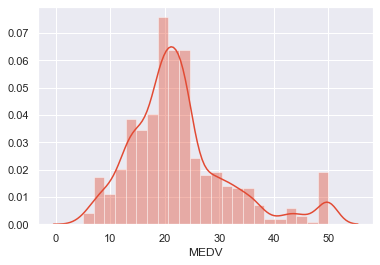

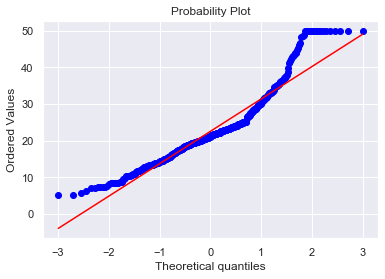

In [54]:
# histogram and normal probability plot
sns.distplot(y, hist = True)
fig = plt.figure()
res = stats.probplot(y, plot = plt)

Notice how the response variable doesn't strictly follow a Normal distribution as it should. Having said that, with such a large sample size of 506, we can forgo this assumption in favor of the Central Limit Theorem which stipulates that the data conforms to a Normal distribution at a large enough sample size.

### Assumptions

To be able to apply linear regression analysis, we have to ensure that the assumptions are fulfilled. These are as follows: 

1. Linearity of the residuals
2. Independence of the residuals
3. Normality of the residuals with a mean of 0
4. Constant variance of the residuals

In [55]:
# Data Preparation
X = X[['RM', 'LSTAT']]
# split between training and testing sets, (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# scaling the data
scaler = StandardScaler().fit(X_train)

# scaling the training and test splits and adding the column names back
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [56]:
# function that finds the mean of the residuals, tests for Normality and independence

def residual_tests(residuals):
    
    # Mean of the residuals
    residuals_mean = round(np.mean(residuals), 3)
    print("{} is the mean of the residuals.".format(residuals_mean))
    
    # Checking for Normality of the residuals, Shapiro-Wilk test
    W_stat, p = stats.shapiro(residuals)
    W_stat = round(W_stat, 3)
    p = round(p, 3)
    print("{} is the test-statistic for the Shapiro-Wilk test with a p-value of {}.".format(W_stat, p))
    if p < 0.05: 
        print("We conclude that the residuals are not Normally distributed.")
    else:
        print("We conclude that the residuals are Normally distributed.")
    
    # Checking independence of the residuals, Durbin-Watson test
    dw = round(durbin_watson(residuals), 3)
    print("{} is the test-statistic for the Durbin-Watson test.".format(dw))
    if dw > 2.5 and dw <= 4:
        print("We conclude there is strong negative autocorrelation in the residuals.")
    if dw > 0 and dw < 1.5:
        print("We conclude there is strong positive autocorrelation in the residuals.")
    else:
        print("We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.")

In [57]:
# function that plots the predicted values against the true values, the residual plot, and the QQ-plot of the residuals
# requires seaborn and matplotlib.pyplot

def plot_model_diagnostics(y_pred, y_test, residuals):
    
    # Predictions vs True Values
    plt.figure()
    sns.regplot(x = y_pred, y = y_test, ci = None, scatter_kws = {'color': 'b'}, line_kws = {'color': 'r'})
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title("Predictions vs True Values")
    
    # Residual Plot
    plt.figure()
    sns.residplot(x = y_pred, y = y_test, lowess = True, scatter_kws = {'color': 'b'}, line_kws = {'color': 'r'})
    plt.title("Residual Plot")
    
    # QQ-plot
    plt.figure()
    stats.probplot(residuals, plot = plt)
    plt.title("QQ-plot of the Residuals")

In [58]:
# function to plot variable importance, only works for estimators with feature_importances_ attribute

def plot_variable_importance(model):
    
    importances = model.best_estimator_.feature_importances_

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Rearrange feature names so they match the sorted feature importances
    names = list(X.columns.values)
    names = [names[i] for i in indices]
    
    # Create plot
    plt.figure()
    plt.title("Feature Importance")
    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), names, rotation=90)
    plt.show()

In [59]:
# function to plot 3D scatterplot of the model

def plot_3d_scatter(X_test, y_pred, y_test, x, y, z, title, color):

    test_df = X_test.copy()
    test_df['MEDV_pred'] = y_pred.tolist()
    test_df['MEDV_true'] = y_test.tolist()
    test_df['Residual'] = test_df['MEDV_true'] - test_df['MEDV_pred']
    
    # Visualizing the OLS Predictions
    plt.figure()
    fig = px.scatter_3d(test_df, x = x, y = y, z = z, 
                        title = title,
                        color = color)
    fig.show()

### Building Models

#### Ordinary Least Squares (OLS) Regression
First we will start with the simplest of machine learning algorithms, the ordinary least squares linear regression model. We use the function to fit the model and test it against the assumptions, so that we can evaluate the strength of the model within context. We can also help diagnose model issues by plotting the predictions against the true values and plot the residuals as well.

The implementation of multiple linear regression with multiple features (independent variables) appears like so:

$$ y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n $$ 

Where $y$ is the response, $x_i$ is the feature (or input variable), $\beta_0$ is the intercept, and $\beta_1$ through $\beta_n$ are the coefficients for each of the $n$ independent variables.

38.397 is the Mean Squared Error.
6.197 is the Root Mean Squared Error.
0.621 is the R-squared.
-0.012 is the mean of the residuals.
0.846 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.106 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


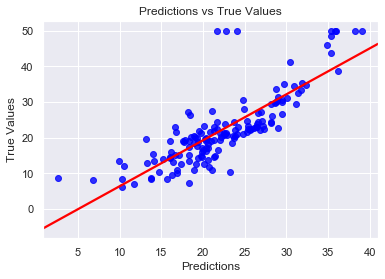

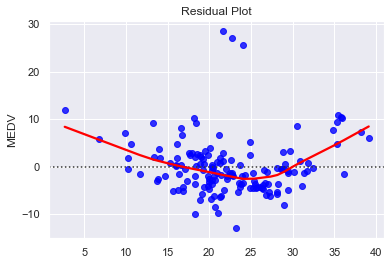

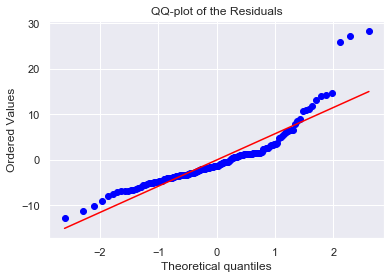

<Figure size 432x288 with 0 Axes>

In [60]:
# Linear Regression Model
regr_LR = LinearRegression()

# Hyper-parameter tuning
parameters_LR = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
grid_LR = GridSearchCV(estimator = regr_LR, param_grid = parameters_LR)
model_LR = grid_LR.fit(X_train, y_train)
predictions_LR = model_LR.predict(X_test)

# MSE 
mse_LR = round(mean_squared_error(y_test, predictions_LR), 3)
rmse_LR = round(np.sqrt(mse_LR), 3)
print("{} is the Mean Squared Error.".format(mse_LR))
print("{} is the Root Mean Squared Error.".format(rmse_LR))

# R-squared
r2_LR = round(model_LR.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_LR))
    
# Residuals
residuals_LR = y_test - predictions_LR
residual_tests(residuals_LR)

# Plotting model diagnostics
plot_model_diagnostics(predictions_LR, y_test, residuals_LR)

# Plotting model
plot_3d_scatter(X_test, predictions_LR, y_test, x = 'RM', y = 'LSTAT', z = 'MEDV_pred',
               title = 'Plot of Predictions from OLS Model', color = 'Residual')

We see that the mean of the residuals is approximately zero and that they are also independently distributed. Although the residuals of the model are not from a Normal distribution based on our tests and this QQ-plot, the sample size (504) is sufficiently large enough for us to bypass this assumption. In practice, residuals seldom fulfill this requirement. 

Looking at the residual plot however, we see a trend in how they are distributed (note the curve in the red line). Ideally this red line would be as horizontal as possible. Note the imbalance on the Y-axis with how the residuals are distributed. These all point towards the conclusion that this model might not be the strongest. 

### Decision Tree

Decision trees are a simple machine learning model that can be utilized for classification and also for regression, which is our use case. The algorithm works in much the same way it does for a classification problem as it does for regression, where it chooses a label. In the regression case, it chooses between 'leaves' which are the splits in the data. 

For example, suppose in our training set we have values for $x$ ranging from 1-100, and each value for $x$ corresponds to a value for $y$. The algorithm can split these values  into ranges, such as 1-25, 25-50, 50-75, 75-100. It will then take a value for $y$ that represents that range for $x$. 

33.066 is the Mean Squared Error.
5.75 is the Root Mean Squared Error.
0.674 is the R-squared.
0.44 is the mean of the residuals.
0.803 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.128 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


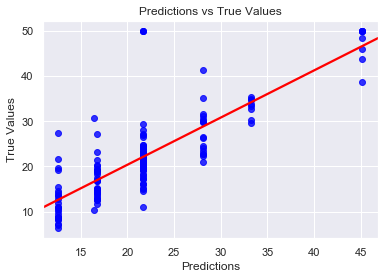

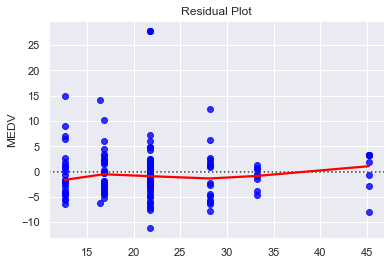

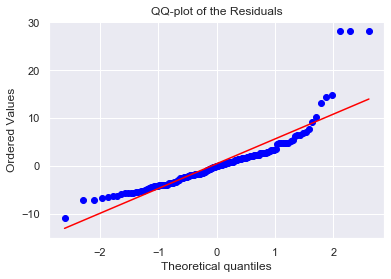

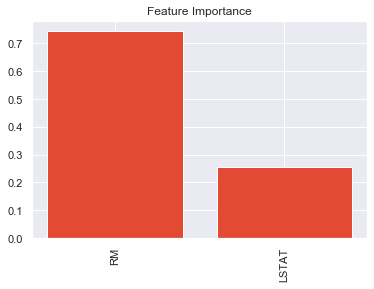

<Figure size 432x288 with 0 Axes>

In [61]:
# Decision Tree Regression
regr_DT = DecisionTreeRegressor(random_state = 10)

# Hyper-parameter tuning
parameters_DT = {'max_features': ['sqrt', 'log2', None], 'max_depth': range(2,20)}
grid_DT = GridSearchCV(estimator = regr_DT, param_grid = parameters_DT)
model_DT = grid_DT.fit(X_train, y_train)
predictions_DT = model_DT.predict(X_test)

# MSE 
mse_DT = round(mean_squared_error(y_test, predictions_DT), 3)
rmse_DT = round(np.sqrt(mse_DT), 3)
print("{} is the Mean Squared Error.".format(mse_DT))
print("{} is the Root Mean Squared Error.".format(rmse_DT))

# R-squared
r2_DT = round(model_DT.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_DT))
    
# Residuals
residuals_DT = y_test - predictions_DT
residual_tests(residuals_DT)

# Plotting
plot_model_diagnostics(predictions_DT, y_test, residuals_DT)

# Plotting variable importance
plot_variable_importance(model_DT)

# Plotting model
plot_3d_scatter(X_test, predictions_DT, y_test, x = 'RM', y = 'LSTAT', z = 'MEDV_pred',
               title = 'Plot of Predictions from Decision Tree Model', color = 'Residual')

### Random Forest
Random forest is a machine learning algorithm that, true to its name, utilizes decision trees. It is a bootstrap aggregation (bagging) method that leverages many decision trees. This ensemble learning technique helps minimize overfitting which is a problem common when utilizing decision trees. It also introduces an element of randomness that makes it more robust. 

While Random Forests, like decision trees, can be utilized for classification, this is a regression problem since we are predicting a continuous response variable rather than a categorical one. 

It works by sampling multiple subsamples (with replacement) from the training dataset, then trains many decision trees for regression, where each leaf node outputs the mean of all of the label values in the node itself. The "forest" then returns the average of the predictions of all of the decision trees. 

While the randomness and scale of the algorithm makes it effectively reduce overfitting, it suffers from a lack of interpretability, making it a 'black-box' algorithm. 

29.908 is the Mean Squared Error.
5.469 is the Root Mean Squared Error.
0.705 is the R-squared.
0.306 is the mean of the residuals.
0.798 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.136 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


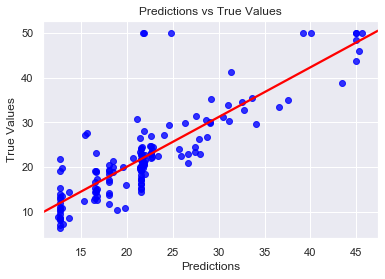

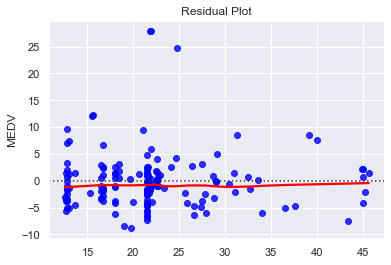

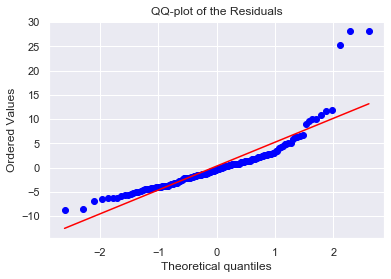

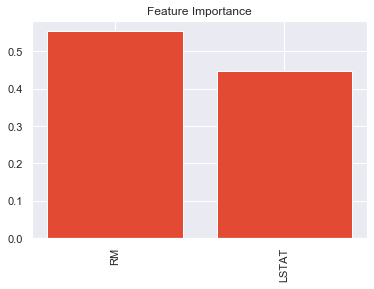

<Figure size 432x288 with 0 Axes>

In [62]:
# Random Forest Regressor
regr_RF = RandomForestRegressor()

# Hyper-parameter tuning
parameters_RF = {'n_estimators': [10, 20, 50, 100, 400], 
                'max_depth': [3, None],
                'max_features': [1,2]}
grid_RF = GridSearchCV(estimator = regr_RF, param_grid = parameters_RF)
model_RF = grid_RF.fit(X_train, y_train)
predictions_RF = model_RF.predict(X_test)

# MSE 
mse_RF = round(mean_squared_error(y_test, predictions_RF), 3)
rmse_RF = round(np.sqrt(mse_RF), 3)
print("{} is the Mean Squared Error.".format(mse_RF))
print("{} is the Root Mean Squared Error.".format(rmse_RF))

# R-squared
r2_RF = round(model_RF.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_RF))
    
# Residuals
residuals_RF = y_test - predictions_RF
residual_tests(residuals_RF)

# Plotting
plot_model_diagnostics(predictions_RF, y_test, residuals_RF)

# plot variable importance
plot_variable_importance(model_RF)

# Plotting model
plot_3d_scatter(X_test, predictions_RF, y_test, 
                x = 'RM', y = 'LSTAT', z = 'MEDV_pred',
                title = 'Plot of Predictions from Random Forest Model', color = 'Residual')

### Gradient Boosting

Boosting is a sequential technique which works on the principle of tree ensembles, like random forests. The basic idea behind boosting algorithms is building a weak model, making conclusions about the various feature importance and parameters, and then using those conclusions to build a new, stronger model. One of the drawbacks of a single decision/regression tree is that it fails to include predictive power from multiple, overlapping regions of the feature space.

Gradient boosting works by fitting a model to the data, $F_1(x) = y$, then fits a model to the residuals, $h_1(x) = y - F_1(x)$, and then creates a new model, $F_2(x) = F_1(x) + h_1(x)$, and it continues over and over.

29.235 is the Mean Squared Error.
5.407 is the Root Mean Squared Error.
0.711 is the R-squared.
0.324 is the mean of the residuals.
0.801 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.122 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


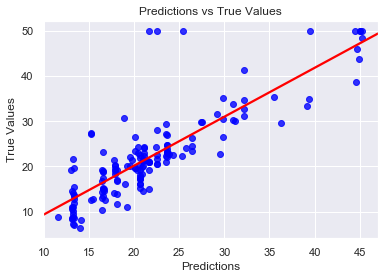

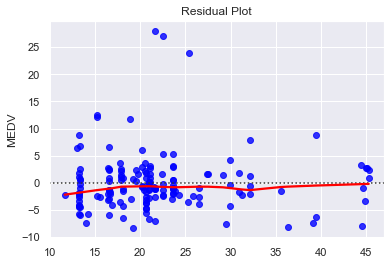

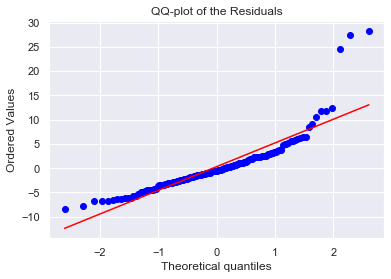

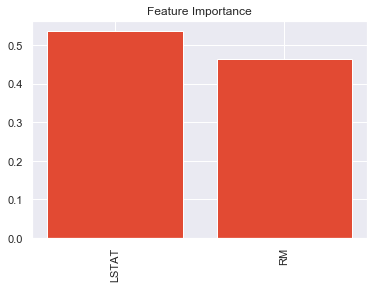

<Figure size 432x288 with 0 Axes>

In [63]:
# Gradient Boosting Regressor
regr_XGB = XGBRegressor(random_state = 10)

# Hyper-parameter tuning
parameters_XGB = {'n_estimators': [10, 20, 50, 100, 400], 'max_depth': [2,5,7,9], 'min_samples_split': [2,3,4,5],
                 'learning_rate': [0.1, 0.2], 'loss': ['ls']}
grid_XGB = GridSearchCV(estimator = regr_XGB, param_grid = parameters_XGB)
model_XGB = grid_XGB.fit(X_train, y_train)
predictions_XGB = model_XGB.predict(X_test)

# MSE 
mse_XGB = round(mean_squared_error(y_test, predictions_XGB), 3)
rmse_XGB = round(np.sqrt(mse_XGB), 3)
print("{} is the Mean Squared Error.".format(mse_XGB))
print("{} is the Root Mean Squared Error.".format(rmse_XGB))

# R-squared
r2_XGB = round(model_XGB.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_XGB))
    
# Residuals
residuals_XGB = y_test - predictions_XGB
residual_tests(residuals_XGB)

# Plotting
plot_model_diagnostics(predictions_XGB, y_test, residuals_XGB)

# plot variable importance
plot_variable_importance(model_XGB)

# Plotting model
plot_3d_scatter(X_test, predictions_XGB, y_test, 
                x = 'RM', y = 'LSTAT', z = 'MEDV_pred', 
                title = 'Plot of Predictions from Gradient Boosting Model', color = 'Residual')

### k-Nearest Neighbors

Unlike decision trees and random forests, k-Nearest Neighbors is an unsupervised learning technique. It can also be utilized for both classification and regression. This algorithm uses "feature similarity" to predict the values of new data points, which means that predictions are made based on how closely a given value resembles others in the data set. The name of the algorithm refers to the number of "neighbors" (or nearby data point), $k$, that are considered when determining the predicted value of a data point.

31.013 is the Mean Squared Error.
5.569 is the Root Mean Squared Error.
0.694 is the R-squared.
0.02 is the mean of the residuals.
0.776 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.177 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


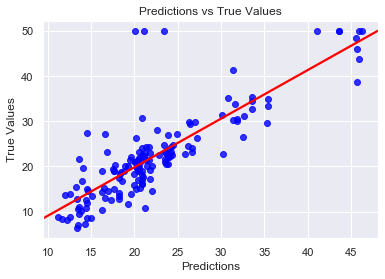

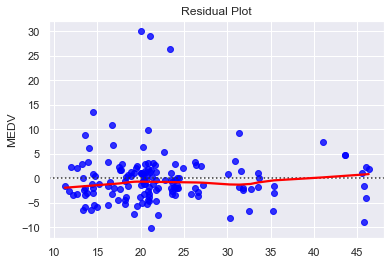

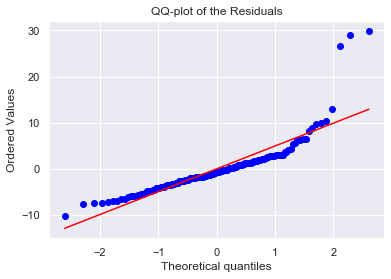

<Figure size 432x288 with 0 Axes>

In [64]:
# KNN Regression
regr_KNN = KNeighborsRegressor()

# Hyper-parameter tuning
parameters_KNN = {'n_neighbors': range(1,11), 'weights': ['uniform', 'distance'], 
                 'metric': ['euclidean', 'manhattan'],
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_KNN = GridSearchCV(estimator = regr_KNN, param_grid = parameters_KNN)
model_KNN = grid_KNN.fit(X_train, y_train)
predictions_KNN = model_KNN.predict(X_test)

# MSE 
mse_KNN = round(mean_squared_error(y_test, predictions_KNN), 3)
rmse_KNN = round(np.sqrt(mse_KNN), 3)
print("{} is the Mean Squared Error.".format(mse_KNN))
print("{} is the Root Mean Squared Error.".format(rmse_KNN))

# R-squared
r2_KNN = round(model_KNN.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_KNN))
    
# Residuals
residuals_KNN = y_test - predictions_KNN
residual_tests(residuals_KNN)

# Plotting
plot_model_diagnostics(predictions_KNN, y_test, residuals_KNN)

# Plotting model
plot_3d_scatter(X_test, predictions_KNN, y_test, 
                x = 'RM', y = 'LSTAT', z = 'MEDV_pred',
                title = 'Plot of Predictions from k-Nearest Neighbors Model', color = 'Residual')

### Comparing Algorithms

Now that we have calculated the MSE and the R-squared for all of the different models, we want to compare them. We want to minimize the MSE and maximize the R-squared. In order to pick the best model, we can plot these two values for each of the models onto a scatterplot. The best model would have a low MSE and a high R2, so ideally it would be in the upper left quadrant of the plot, where MSE is on the x-axis and R-squared in on the y-axis.

             Algorithm    MSE  RMSE    R2
0       OLS Regression  38.40  6.20  0.62
1        Decision Tree  33.07  5.75  0.67
2        Random Forest  29.91  5.47  0.70
3    Gradient Boosting  29.23  5.41  0.71
4  k-Nearest Neighbors  31.01  5.57  0.69


Text(0.5, 1.0, 'MSE vs R-squared, by Algorithm, Small Models')

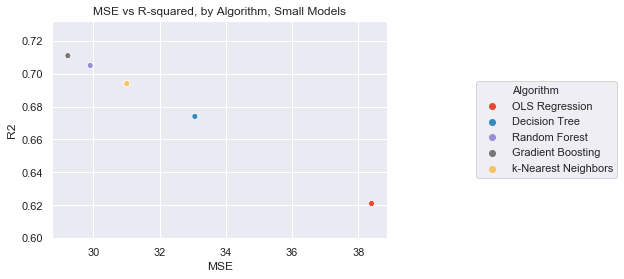

In [65]:
# Initializing a matrix that will be filled with MSE and R-squared
records_full = []
algorithms = ('OLS Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'k-Nearest Neighbors')
mse_all = (mse_LR, mse_DT, mse_RF, mse_XGB, mse_KNN)
rmse_all = (rmse_LR, rmse_DT, rmse_RF, rmse_XGB, rmse_KNN)
r2_all = (r2_LR, r2_DT, r2_RF, r2_XGB, r2_KNN)

# Filling matrix in with values
for i in range(0,5):
    records_full.append({'Algorithm': algorithms[i], 
                         'MSE': mse_all[i], 
                         'RMSE': rmse_all[i],
                         'R2': r2_all[i]})

# converting into a DataFrame
records_full = pd.DataFrame(records_full)
print(records_full)

plt.figure()
g = sns.scatterplot(x = 'MSE', y = 'R2', data = records_full, hue = 'Algorithm')
g.legend(loc = 'center left', bbox_to_anchor = (1.25, 0.5), ncol = 1)
plt.title('MSE vs R-squared, by Algorithm, Small Models')

## Predictions
Now that we know which model is the best, we can use it to generate predictions. Again the response variable in this case is `MEDV` or the median value of the home, in the thousands. Our independent variables are `LSTAT`, the % lower status of the population, and `RM` the average number of rooms. So suppose we have a new house whose `LSTAT` is 14 and whose `RM` is 6.

Recall that the training and the test data were scaled to a Normal distribution with the `StandardScaler` function. We will have to scale any new input data as well so that our model can recognize it.

It's important also to note that the gradient boosted model, as well as the random forest and decision tree models, are not good at extrapolating to data that is outside of the range the data was trained on. For example, if the data was only taught to predict `MEDV` based on values of `RM` between 3 and 10, it will not have a good prediction for an `RM` of 12. This is a problem inherent to decision tree models and the models that utilize them e.g. gradient boosting trees, random forest. 

In [66]:
# Creating new data
new_data = pd.DataFrame({'RM': [6], 'LSTAT': [14]})
# scaling new data
new_data = scaler.transform(new_data)
new_data = pd.DataFrame(new_data, columns = ['RM', 'LSTAT'])
# Prediction
model_XGB.predict(new_data)[0]

20.005268

As you can see the expected value for `MEDV` is about 20, or \$20k.

### Creating a GUI Application to Make Predictions

This lightweight program using `tkinter` creates a window that accepts input for values of `LSTAT` and `RM` and returns a value for `MEDV`.

In [67]:
def call_result(label_result, n1, n2):
    num1 = (n1.get())
    num2 = (n2.get())

    new_data = pd.DataFrame({'RM': [num1], 'LSTAT': [num2]})
    new_data = scaler.transform(new_data)
    new_data = pd.DataFrame(new_data, columns = ['RM', 'LSTAT'])

    result = model_XGB.predict(new_data)[0]
    label_result.config(text="Result is %d" % result)
    return

root = tk.Tk()
root.geometry('400x200+100+200')
root.title('Prediction with Regression Model')

number1 = tk.StringVar()
number2 = tk.StringVar()

label_Title = tk.Label(root, text = 'Prediction with Regression Model').grid(row = 0, column = 2)
label_Num1 = tk.Label(root, text = 'Enter the value for RM').grid(row = 1, column = 0)
label_Num2 = tk.Label(root, text = 'Enter the value for LSTAT').grid(row = 2, column = 0)
label_Result = tk.Label(root)
label_Result.grid(row = 7, column = 2)


entry_Num1 = tk.Entry(root, textvariable = number1).grid(row=1, column=2)
entry_Num2 = tk.Entry(root, textvariable = number2).grid(row=2, column=2)

call_result = partial(call_result, label_Result, number1, number2)
buttonCal = tk.Button(root, text = "Calculate", command = call_result).grid(row = 3, column = 0)
root.mainloop()